In [467]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_bvp, solve_ivp
from scipy.optimize import root

%run simulation
%run control
%run plotting

#from simulation import *
#from control import *
#from plotting import *

plt.style.use("dark_background")

In [457]:
# Set up initial conditions and parameters
t0 = 0
tf = 5
x0 = np.array([0, 0])
v0 = np.array([2, 1])
masses = np.array([1,1,0])

init = np.array([1, 1, 0, # Position 1
                 -1, -1, 0, # Position 2
                 *x0, 0, # Position 3
                 .35, -.25, 0, # Velocity/Momentum 1
                 -.35, .25, 0, # Velocity/Momentum 2
                 *v0, 0]) # Velocity 3 

# Solve the system
f = lambda t, y: gravity_acceleration_general(y, m=masses)
sol = solve_ivp(gravity_acceleration, (t0, tf), init, t_eval= np.linspace(t0, tf, 1000), dense_output=True)

#initial setup for the optimal control
t_guess = 1.05
m0 = np.array([2])
target = np.array([0.5,1.5])

t_guess = 1.05, Position: [0.40904719 1.40505742]


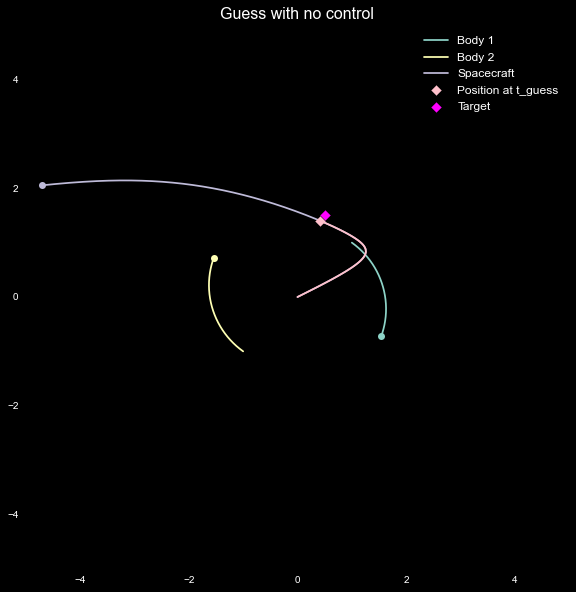

In [458]:
#Plot the initial system
pos_guess = plot_guess_vs_target(sol, t_guess, target)

In [385]:
sol2, u = solve_optimal_euclidean(sol, masses[:-1], x0, v0, m0, target, delta=100, tf_guess=t_guess, p12_guess_strat="bolza",
                                  verbose=2, max_nodes=20_000)

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          6.89e+01       9.53e+00          100            198      
       2          1.11e+02       6.86e+00          298            594      
       3          3.81e+02       3.22e+00          892           1782      
       4          6.26e+02       2.32e-02         2674           4828      
       5          8.93e+02       4.21e-02         7502          (14052)    
Number of nodes is exceeded after iteration 5. 
Maximum relative residual: 8.93e+02 
Maximum boundary residual: 4.21e-02


t_f = 1.0499845976469941
m_f = 1.341034038459784
x(t_f) =  [0.50157442 1.49710382]
v(t_f) =  [-1.49721973  0.83984533]


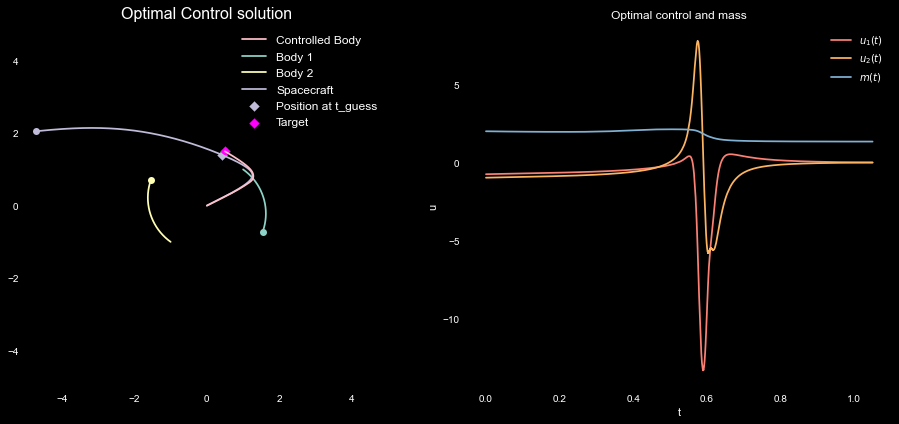

In [459]:
plot_control(sol, sol2, u, pos_guess, target)

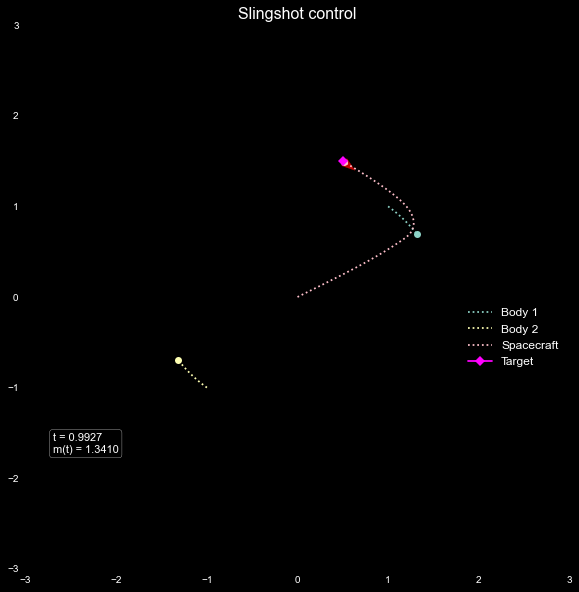

In [499]:
%run plotting

plt.style.use("dark_background")
animate_control(sol, sol2, u, pos_guess, target, "slingshot_control_test", title="Slingshot control", lim=(-3,3))

<video src="../Animations/slingshot_control_test.mp4" controls></video>

-0.7484077424669978 -0.9711748044232619


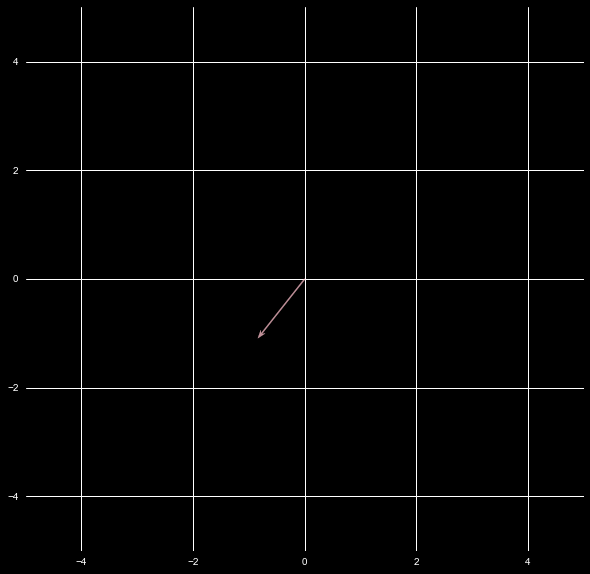

In [489]:
ax = plt.gca()
print(*u[:,0])
plt.xlim(-5,5)
plt.ylim(-5,5)
control_arrow = ax.arrow(*sol2.y[:2, 0], *u[:,0], alpha=0.75, overhang=0.3, width=0.02, head_width=0.1, color='pink')

Use this code to embed an animation:
    
    <video src="../Animations/your_animation_name.mp4" controls></video>